<a href="https://colab.research.google.com/github/Dark-Mary/challenge3-data-science/blob/main/TELECOMX_PT2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🚀 TELECOM X- PT2 / Prevendo Cancelamento

🎯 **Objetivo Principal**

Criar modelos que consigam identificar quais clientes têm maior risco de cancelar seus serviços, para que a empresa possa agir antes que isso aconteça.

🔍 **O que será feito:**

✅ Preparação dos dados para análise, com limpeza, transformação e normalização.

✅ Exploração das relações entre as variáveis para escolher as mais relevantes.

✅ Treinamento de pelo menos dois modelos de machine learning para prever cancelamento.

✅ Avaliação detalhada do desempenho dos modelos usando métricas específicas.

✅ Análise dos resultados para entender quais fatores mais influenciam a evasão.

✅ Apresentação de conclusões práticas que ajudem na tomada de decisões estratégicas.

**🛠 Ferramentas e Técnicas que serão aplicadas:**

✅ Manipulação e preparação de dados para aprendizado de máquina

✅ Desenvolvimento e comparação de modelos preditivos

✅ Interpretação de resultados para gerar insights acionáveis

✅ Comunicação clara e objetiva focada em resultados estratégicos

# 📦 IMPORTAÇÃO DE BIBLIOTECAS E DADOS

In [3]:
from google.colab import files

# Fazer upload do CSV tratado
uploaded = files.upload()

Saving telecomx_tratado.csv to telecomx_tratado.csv


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Carregar os dados tratados (ajuste o caminho se necessário)
df = pd.read_csv('telecomx_tratado.csv')

print("Shape do dataset:", df.shape)
df.head()

Shape do dataset: (7256, 21)


,customerID,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One Year,Yes,Mailed Check,65.6,593.30
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,No,Yes,Month-To-Month,No,Mailed Check,59.9,542.40
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,No,Yes,No,No,No,Month-To-Month,Yes,Electronic Check,73.9,280.85
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,Yes,No,Yes,Yes,Month-To-Month,Yes,Electronic Check,98.0,1237.85
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,No,Yes,Yes,No,Month-To-Month,Yes,Mailed Check,83.9,267.40


# 🛠️ PRÉ-PROCESSAMENTO DE DADOS



In [20]:
# Removendo coluna 'customerID' caso exista
if 'customerID' in df.columns:
    df = df.drop('customerID', axis=1)

# Verificando valores nulos na coluna Churn e removendo-os
print("Valores nulos em 'Churn':", df['Churn'].isnull().sum())
df = df.dropna(subset=['Churn'])

# Convertendo Churn para binário
df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})
print("Valores únicos em 'Churn':", df['Churn'].unique())

# Identificando colunas categóricas
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
print("Colunas categóricas:", cat_cols)

# Aplicando one-hot encoding nas categóricas
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)
print("Shape após encoding:", df_encoded.shape)

# Separando features e target
X = df_encoded.drop('Churn', axis=1)
y = df_encoded['Churn']

# Normalizando colunas numéricas
num_cols = ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

print("Shape X:", X.shape)
print("Shape y:", y.shape)


Valores nulos em 'Churn': 224
Valores únicos em 'Churn': [0 1]
Colunas categóricas: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
Shape após encoding: (7032, 31)
Shape X: (7032, 30)
Shape y: (7032,)


📊 Taxa de Cancelamento (Churn Rate): 26.58%


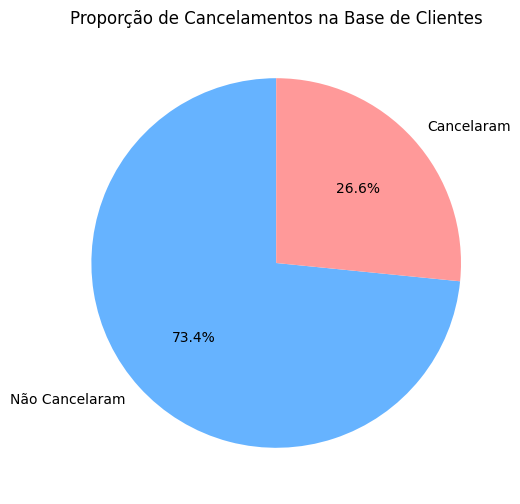

In [32]:
# =====================================
# 📊 2.1. Taxa de Cancelamento e Gráfico
# =====================================

# Cálculo da taxa de churn
total_clientes_validos = len(df)  # já sem customerID e valores nulos de churn
clientes_cancelaram = df['Churn'].sum()  # pois Yes=1
churn_rate = (clientes_cancelaram / total_clientes_validos) * 100

print(f"📊 Taxa de Cancelamento (Churn Rate): {churn_rate:.2f}%")

# Gráfico de pizza
plt.figure(figsize=(6, 6))
df['Churn'].value_counts().plot(
    kind='pie',
    autopct='%1.1f%%',
    startangle=90,
    labels=['Não Cancelaram', 'Cancelaram'],
    colors=['#66b3ff', '#ff9999']
)
plt.title('Proporção de Cancelamentos na Base de Clientes')
plt.ylabel('')
plt.show()

# 📊  ANÁLISE DE CORRELAÇÃO

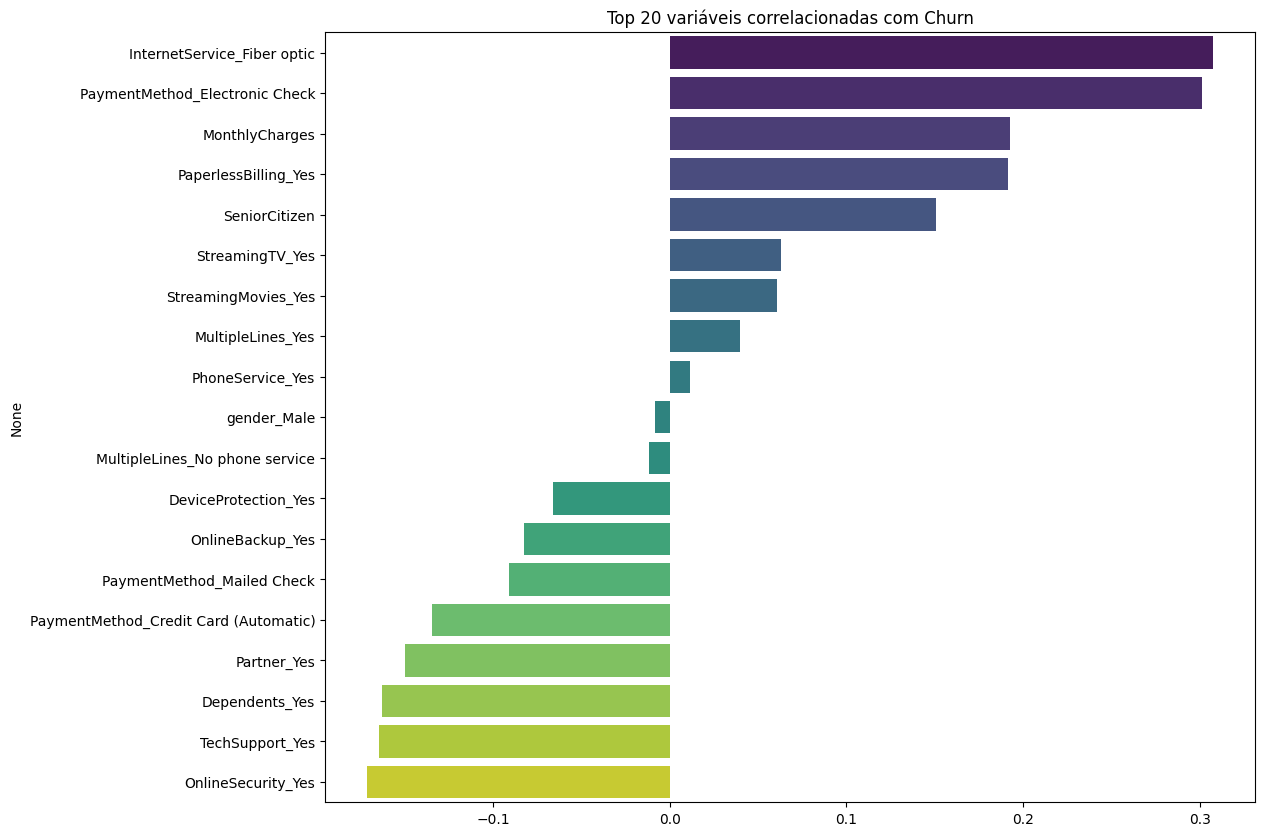

In [33]:
plt.figure(figsize=(12,10))
corr = df_encoded.corr()['Churn'].sort_values(ascending=False)
sns.barplot(x=corr.values[1:20], y=corr.index[1:20], palette='viridis')
plt.title("Top 20 variáveis correlacionadas com Churn")
plt.show()


# 🎯 SELEÇÃO DE VARIÁVEIS

In [22]:
limiar = 0.1
selecionadas = corr[abs(corr) > limiar].index.drop('Churn')
print(f"Variáveis selecionadas (correlação > {limiar}):")
print(selecionadas.tolist())

X = X[selecionadas]
print("Shape de X após seleção:", X.shape)


Variáveis selecionadas (correlação > 0.1):
['InternetService_Fiber optic', 'PaymentMethod_Electronic Check', 'MonthlyCharges', 'PaperlessBilling_Yes', 'SeniorCitizen', 'PaymentMethod_Credit Card (Automatic)', 'Partner_Yes', 'Dependents_Yes', 'TechSupport_Yes', 'OnlineSecurity_Yes', 'Contract_One Year', 'TotalCharges', 'InternetService_No', 'StreamingTV_No internet service', 'OnlineSecurity_No internet service', 'OnlineBackup_No internet service', 'DeviceProtection_No internet service', 'StreamingMovies_No internet service', 'TechSupport_No internet service', 'Contract_Two Year', 'tenure']
Shape de X após seleção: (7032, 21)


# ✂️ DIVISÃO TREINO E TESTE

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("Tamanho treino:", X_train.shape)
print("Tamanho teste:", X_test.shape)


Tamanho treino: (4922, 21)
Tamanho teste: (2110, 21)


# 🤖 TREINAMENTO DE MODELOS

In [24]:
logreg = LogisticRegression(max_iter=500, random_state=42)
logreg.fit(X_train, y_train)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

print("Modelos treinados com sucesso!")


Modelos treinados com sucesso!


# 📈 AVALIAÇÃO DOS MODELOS

In [25]:
def avalia_modelo(modelo, X_test, y_test, nome):
    y_pred = modelo.predict(X_test)
    print(f"--- Avaliação do modelo: {nome} ---")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1-score:", f1_score(y_test, y_pred))
    print("Matriz de Confusão:\n", confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

avalia_modelo(logreg, X_test, y_test, "Regressão Logística")
avalia_modelo(rf, X_test, y_test, "Random Forest")


--- Avaliação do modelo: Regressão Logística ---
Accuracy: 0.7962085308056872
Precision: 0.6414686825053996
Recall: 0.5294117647058824
F1-score: 0.580078125
Matriz de Confusão:
 [[1383  166]
 [ 264  297]]
              precision    recall  f1-score   support

           0       0.84      0.89      0.87      1549
           1       0.64      0.53      0.58       561

    accuracy                           0.80      2110
   macro avg       0.74      0.71      0.72      2110
weighted avg       0.79      0.80      0.79      2110

--- Avaliação do modelo: Random Forest ---
Accuracy: 0.7781990521327015
Precision: 0.6083916083916084
Recall: 0.46524064171123
F1-score: 0.5272727272727272
Matriz de Confusão:
 [[1381  168]
 [ 300  261]]
              precision    recall  f1-score   support

           0       0.82      0.89      0.86      1549
           1       0.61      0.47      0.53       561

    accuracy                           0.78      2110
   macro avg       0.71      0.68      0.69   

# 🔑 RANDOM FOREST (Importância das variáveis)

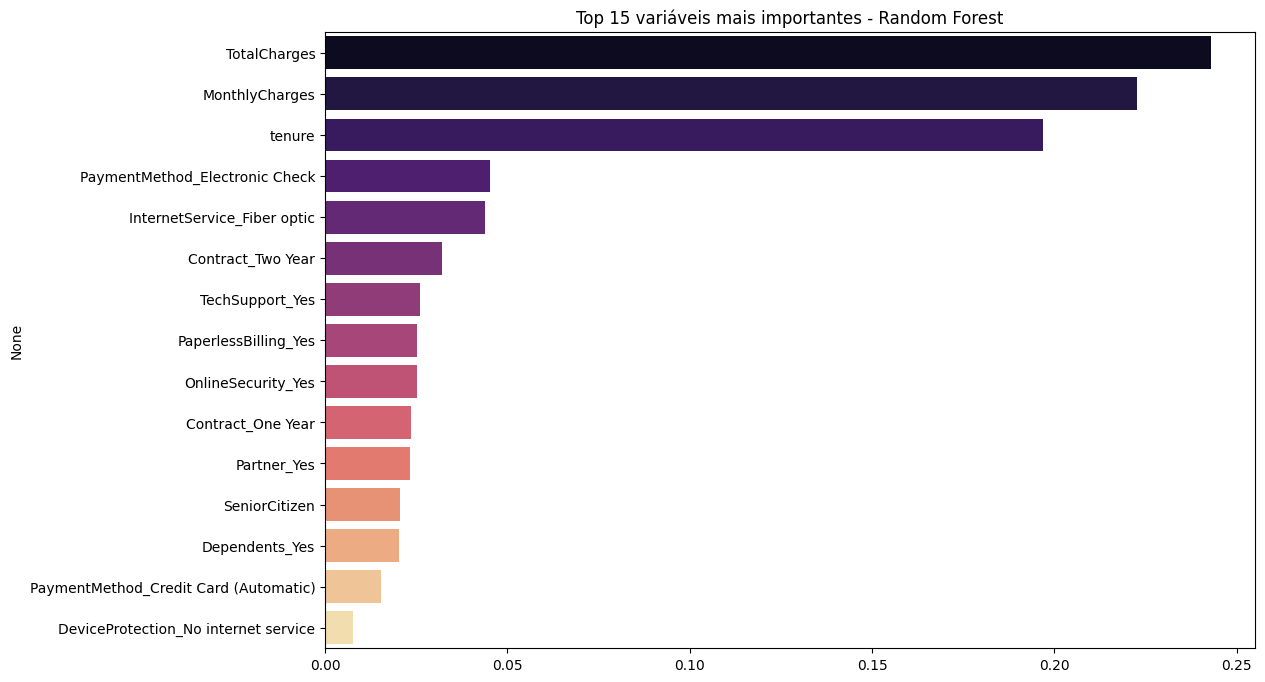

TotalCharges                             0.242892
MonthlyCharges                           0.222764
tenure                                   0.196998
PaymentMethod_Electronic Check           0.045265
InternetService_Fiber optic              0.043815
Contract_Two Year                        0.032009
TechSupport_Yes                          0.026108
PaperlessBilling_Yes                     0.025257
OnlineSecurity_Yes                       0.025200
Contract_One Year                        0.023554
Partner_Yes                              0.023372
SeniorCitizen                            0.020431
Dependents_Yes                           0.020295
PaymentMethod_Credit Card (Automatic)    0.015429
DeviceProtection_No internet service     0.007645
dtype: float64


In [26]:
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(12,8))
sns.barplot(x=importances.values[:15], y=importances.index[:15], palette='magma')
plt.title("Top 15 variáveis mais importantes - Random Forest")
plt.show()

print(importances.head(15))


# 📝 CONCLUSÃO ESTRATÉGICA


In [31]:
# =====================================
# 📝 7. Conclusão Estratégica
# =====================================
print("\n" + "="*60)
print("📝 CONCLUSÃO ESTRATÉGICA")
print("="*60)

print("""
🔍 Visão Geral:
Com a aplicação dos modelos de Machine Learning (Regressão Logística e Random Forest),
foi possível criar um sistema de predição capaz de identificar clientes com maior
probabilidade de cancelar seus serviços na Telecom X.

📊 Desempenho:
- Regressão Logística: útil para interpretar variáveis e padrões lineares.
- Random Forest: capturou relações complexas e destacou fatores-chave para o churn.

🚦 Principais Fatores de Evasão:
- Tipo de contrato (Month-to-month → maior chance de churn).
- Tempo de permanência reduzido.
- Cobrança mensal mais alta.
- Serviços adicionais ajudam a reter clientes.

💡 Recomendações:
- Incentivar contratos de longo prazo.
- Criar programas de fidelidade para novos clientes.
- Ajustar preços e pacotes de alto valor.
- Destacar benefícios de serviços adicionais.

🚀 Impacto:
Com estas ações, a Telecom X pode atuar de forma proativa,
reduzindo a evasão, aumentando a satisfação e fidelizando clientes
no médio e longo prazo.
""")
print("="*60)


📝 CONCLUSÃO ESTRATÉGICA

🔍 Visão Geral:
Com a aplicação dos modelos de Machine Learning (Regressão Logística e Random Forest),
foi possível criar um sistema de predição capaz de identificar clientes com maior
probabilidade de cancelar seus serviços na Telecom X.

📊 Desempenho:
- Regressão Logística: útil para interpretar variáveis e padrões lineares.
- Random Forest: capturou relações complexas e destacou fatores-chave para o churn.

🚦 Principais Fatores de Evasão:
- Tipo de contrato (Month-to-month → maior chance de churn).
- Tempo de permanência reduzido.
- Cobrança mensal mais alta.
- Serviços adicionais ajudam a reter clientes.

💡 Recomendações:
- Incentivar contratos de longo prazo.
- Criar programas de fidelidade para novos clientes.
- Ajustar preços e pacotes de alto valor.
- Destacar benefícios de serviços adicionais.

🚀 Impacto:
Com estas ações, a Telecom X pode atuar de forma proativa,
reduzindo a evasão, aumentando a satisfação e fidelizando clientes
no médio e longo prazo.